Scripts for regression experiments on mouse

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import mp_run
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
from multiprocessing import Pool, cpu_count


# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


In [2]:
train_source_1 = pd.read_csv('../data/human/GSE221103/normalized/train_source.csv.gz', index_col=0, compression='gzip')
train_target_1 = pd.read_csv('../data/human/GSE221103/normalized/train_target.csv.gz', index_col=0, compression='gzip')
test_source_1 = pd.read_csv('../data/human/GSE221103/normalized/test_source.csv.gz', index_col=0, compression='gzip')
test_target_1 = pd.read_csv('../data/human/GSE221103/normalized/test_target.csv.gz', index_col=0, compression='gzip')

train_source_2 = pd.read_csv('../data/human/GSE221173/normalized/train_source.csv.gz', index_col=0, compression='gzip')
train_target_2 = pd.read_csv('../data/human/GSE221173/normalized/train_target.csv.gz', index_col=0, compression='gzip')
test_source_2 = pd.read_csv('../data/human/GSE221173/normalized/test_source.csv.gz', index_col=0, compression='gzip')
test_target_2 = pd.read_csv('../data/human/GSE221173/normalized/test_target.csv.gz', index_col=0, compression='gzip')

In [3]:
common_exp_genes = list(set(train_source_1.index).intersection(set(train_source_2.index)))

train_source_1 = train_source_1.loc[common_exp_genes]
train_target_1 = train_target_1.loc[common_exp_genes]
test_source_1 = test_source_1.loc[common_exp_genes]
test_target_1 = test_target_1.loc[common_exp_genes]

train_source_2 = train_source_2.loc[common_exp_genes]
train_target_2 = train_target_2.loc[common_exp_genes]
test_source_2 = test_source_2.loc[common_exp_genes]
test_target_2 = test_target_2.loc[common_exp_genes]


In [4]:
train_source_list = [train_source_1, train_source_2]
train_target_list = [train_target_1, train_target_2]
test_source_list = [test_source_1, test_source_2]
test_target_list = [test_target_1, test_target_2]

In [5]:
train_source = pd.concat([train_source_1, train_source_2], axis=1)
train_target = pd.concat([train_target_1, train_target_2], axis=1)
test_source = pd.concat([test_source_1, test_source_2], axis=1)
test_target = pd.concat([test_target_1, test_target_2], axis=1)

In [7]:
network_df = pd.read_csv('../data/human/regnetworkweb.org.network', sep='\t')
regulator_set = set(network_df['regulator'])
target_set = set(network_df['target'])

regulator_set = regulator_set.intersection(set(train_source.index))
target_set = target_set.intersection(set(train_source.index))
all_gene_set = regulator_set.union(target_set)
network_dict = {target: [] for target in target_set}
for ind, row in network_df.iterrows():
    if (row['regulator'] in regulator_set) and (row['target'] in target_set):
        network_dict[row['target']].append(row['regulator'])

key_list = []
value_list = []
regulator_set = set()
tf_list_df = pd.read_csv('../data/human/human_tf_list.tsv.gz', sep='\t', compression='gzip', index_col=0)
for name in tf_list_df['Gene Names']:
    name_splits = str(name).split(' ')
    for i in name_splits:
        if i in train_source.index:
            regulator_set.add(i)
target_set = set()
for key in network_dict.keys():
    if (len(network_dict[key]) > 0) and network_dict[key][0] != key:
        key_list.append(key)
        target_set.add(key)
        value_list.append("; ".join(network_dict[key]))
        for regulator in network_dict[key]:
            regulator_set.add(regulator)
all_gene_set = regulator_set.union(target_set)


In [8]:
network_df = pd.DataFrame(index=key_list)
network_df['tf_list'] = value_list
target_df = pd.concat([train_target, test_target], axis=1)
source_df = pd.concat([train_source, test_source], axis=1)


target_gene_list = list(target_set)
target_exp = target_df.loc[target_gene_list]
X = source_df.loc[list(regulator_set)]
tf_list = list(regulator_set)


tf_list_df = pd.read_csv('../output/network_model/human_tf.csv', names=['tf'], index_col=0)
tf_list = list(tf_list_df.index)

In [11]:
res_df = pd.read_csv('../output/network_model/human_full_results.csv.gz', index_col=0, compression='gzip')
rmse_list = [res_df['rf_rmse'].mean()]
error_list = [res_df['rf_rmse'].sem()]

In [14]:
all_rmse_list = []
all_train_rmse_list = []
all_train_source = pd.concat(train_source_list, axis=1)
all_train_target = pd.concat(train_target_list, axis=1)

for i in range(len(train_source_list)):
    cv_test_source = test_source_list[i]
    cv_test_target = test_target_list[i]
    cv_train_source = train_source_list[i]
    cv_train_target = train_target_list[i]
    new_test_target = cv_test_target.loc[target_gene_list]
    new_test_target = new_test_target.loc[new_test_target.std(axis=1) > 0.5]
    new_target_gene_list = new_test_target.index
    mp_calc = mp_run.MpCalc(new_target_gene_list, X, network_df, cv_train_source.loc[tf_list], cv_train_target, cv_test_source.loc[tf_list], cv_test_target)
    iter_length = len(new_target_gene_list)
    if (iter_length < 1): continue
    with Pool(cpu_count()) as p:
        r = list(tqdm(p.imap(mp_calc.full_comp_new, range(iter_length)), total=iter_length))
    r = np.array(r)
    out_df = pd.DataFrame(index=new_target_gene_list)
    out_df['rf_rmse'] = r[:, 6]
    rmse_list.append(out_df['rf_rmse'].mean())
    error_list.append(out_df['rf_rmse'].sem())
    
    # all_rmse_list = np.concatenate([all_rmse_list, r[:, 6]])
    # print(out_df['rf_rmse'].mean())
    # print(out_df['rf_score'].mean())

    # mp_calc = mp_run.MpCalc(new_target_gene_list, X, network_df, all_train_source.loc[tf_list], all_train_target, cv_test_source.loc[tf_list], cv_test_target)
    # iter_length = len(new_target_gene_list)
    # with Pool(cpu_count()) as p:
    #     r = list(tqdm(p.imap(mp_calc.full_comp_new, range(iter_length)), total=iter_length))
    # r = np.array(r)
    # print(np.mean(r[:, 6]))
    # all_train_rmse_list = np.concatenate([all_train_rmse_list, r[:, 6]])


#     print('======================================')
# print(np.mean(all_rmse_list))
# print(np.mean(all_train_rmse_list))

100%|██████████| 86/86 [00:18<00:00,  4.69it/s]


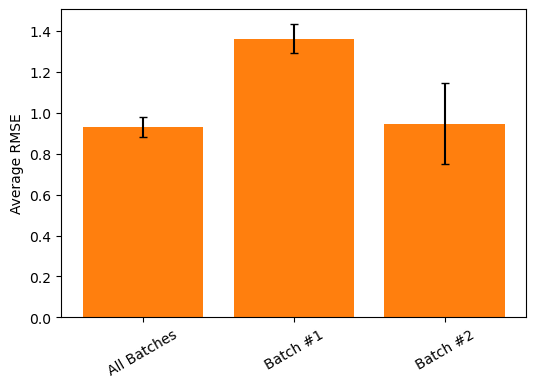

In [21]:

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.bar(['All Batches','Batch #1','Batch #2'], rmse_list, color=colors[1], yerr=error_list, capsize=3)
ax.set(ylabel='Average RMSE')
plt.xticks(rotation=30)
plt.savefig('./plot_output/batch_comp/human.pdf', bbox_inches='tight')